# GLM Tutorial: French Motor Third-Party Liability Claims

This tutorial shows why and how to use Poisson and Gamma GLMs on an insurance claims dataset using scikit-learn, https://github.com/scikit-learn/scikit-learn/pull/9405.

There is a very good tutorial in R for this dataset,
[Case Study: French Motor Third-Party Liability Claims](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764) with [R code](https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/1%20-%20French%20Motor%20Third-Party%20Liability%20Claims).

Insurance claims data consist of the number of claims and the total claim amount. Often, the final goal is to predict the expected value, i.e. the mean, of the total claim amount. There are several possiblities to do that, two of which are:
1. Model total claim amount directly.
2. Model number of claims and claim amount separately with a frequency and a severity model.

We will start with the second option as it shows how to use two different families/distributions within a GLM on a single dataset.

As to why not just use least squares:
<br>
If we fit a GLM, the mean-variance relation of its family=distribution is key. Specifying a family is assuming its mean-variance relationship, which tells the GLM, how much a difference in predicted vs observed target values accounts to how much difference in (estimated parameters of) features. For example, the squared error&mdash;Normal distribution&mdash;is quite famous for being very sensitive to outliers, because it attributes much weight to large deviations. Simply put and slightly overstated: With a Normal distribution, a single large claim amount of only one young driver could result in a high prediction for all young drivers.
<br>
Short version: **The world is not Normal**.

## Table of Contents
* [1 Import Libraries and Helper Functions](#1-import)
* [2 Load and Prepare Datasets from Openml.org](#2-load)
* [3 Feature Transformation Pipeline for GLMs](#3-feature)
* [4 Frequency GLM - Poisson Distribution](#4-frequency)
* [5 Severity GLM - Gamma Distribution](#5-severity)

## 1 Import Libraries and Helper Functions <a class="anchor" id="1-import"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as optimize
import scipy.sparse as sparse
import scipy.special as special
import scipy.stats
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import GeneralizedLinearRegressor, LinearRegression
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, \
    OrdinalEncoder, PolynomialFeatures, StandardScaler

plt.ion()

In [2]:
def var_weighted(x, weights=None, method=1):
    """Calculate weighted sample variance
    See https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance
    https://stats.stackexchange.com/questions/47325/bias-correction-in-weighted-variance
    method=1: v1/(v1**2+v2) * sum(w * (x-mean)**2)
    method=2: 1/(v1*(n-1)) * sum(w * (x-mean)**2)
    """
    x = np.atleast_1d(x)
    if weights is None:
        return np.var(x)
    weights = np.atleast_1d(weights)
    mean = np.average(x, weights=weights)
    v1 = np.sum(weights)
    if method == 1:
        v2 = np.sum(weights**2)
        return v1/(v1**2 - v2) * np.sum((weights/v1) * (x-mean)**2)
    else:
        n = x.shape[0]
        return 1/(n-1) * np.sum((weights/v1) * (x-mean)**2)

In [3]:
def tweedie_deviance(y_true, y_pred, sample_weight=None, p=0):
    y_true = np.atleast_1d(y_true)
    y_pred = np.atleast_1d(y_pred)
    if sample_weight is not None:
        sample_weight = np.atleast_1d(sample_weight)
    if p == 0:  # NormalDistribution
        dev = (y_true - y_pred)**2
    elif p > 0 and p < 1:
        raise ValueError('For 0<p<1, no tweedie deviance exists.')
    elif p == 1:  # PoissonDistribution
        dev = 2 * (special.xlogy(y_true, y_true/y_pred) - y_true + y_pred)
    elif p == 2:  # GammaDistribution
        dev = 2 * (np.log(y_pred/y_true) + y_true/y_pred - 1)
    else:
        dev = 2 * (np.power(np.maximum(y, 0), 2-p)/((1-p)*(2-p)) -
                   y*np.power(mu, 1-p)/(1-p) + np.power(mu, 2-p)/(2-p))
    return np.average(dev, weights=sample_weight)

def poisson_deviance(y_true, y_pred, sample_weight=None):
    return tweedie_deviance(y_true, y_pred, sample_weight=sample_weight, p=1)

def gamma_deviance(y_true, y_pred, sample_weight=None):
    return tweedie_deviance(y_true, y_pred, sample_weight=sample_weight, p=2)

In [4]:
def calc_obs_pred(df, feature, observed, predicted, weight):
    """Calculate a DataFrame with observed and predicted - aggregated per feature level.
    
    This makes most sense for categorical features.
    
    Parameters
    ----------
    df : DataFrame with at least one column named feature
    
    observed : {str, ndarray}
        Either a column name of df or a numpay array with the values of observed target
    
    predicted : {str, ndarray}
        Either a column name of df or a numpay array with the values of predicted target
    
    weight : {str, ndarray}
        Either a column name of df or a numpay array with the values of weights/exposure
        
    Returns
    -------
    df_ : DataFrame with columns ['Observed', 'Predicted']
    """
    df_ = df.loc[:, [feature]].copy()
    if isinstance(observed, str):
        df_['observed'] = df[observed]
    else:
        df_['observed'] = observed
    if isinstance(predicted, str):
        df_['predicted'] = df[predicted]
    else:
        df_['predicted'] = predicted
    if isinstance(weight, str):
        df_['weight'] = df[weight]
    else:
        df_['weight'] = weight
        
    df_['observed'] = df_['observed'] * df_['weight']
    df_['predicted'] = df_['predicted'] * df_['weight']
    df_ = (df_.groupby([feature])['weight', 'observed', 'predicted']
          .sum()
          .assign(observed = lambda x: x['observed']/x['weight'])
          .assign(predicted = lambda x: x['predicted']/x['weight'])
         )
    return df_

def plot_obs_pred(df, feature, observed, predicted, weight,
                  y_label=None, title=None, kind_weight=None):
    """Plot observed and predicted - aggregated per feature level.
    
    Parameters
    ----------
    df : DataFrame with at least one column named feature
    
    observed : {str, ndarray}
        Either a column name of df or a numpay array with the values of observed target
    
    predicted : {str, ndarray}
        Either a column name of df or a numpay array with the values of predicted target
    
    weight : {str, ndarray}
        Either a column name of df or a numpay array with the values of weights/exposure
    """

    df_plot = calc_obs_pred(df, feature, observed, predicted, weight)
    fig, ax1 = plt.subplots(figsize=(8, 6))
    df_plot.loc[:, ['observed', 'predicted']].plot(style='.', ax=ax1)
    if y_label is not None:
        ax1.set_ylabel(y_label)
    ax2 = ax1.twinx()
    if kind_weight=='bar':
        df_plot['weight'].plot(kind='bar', color='g', alpha=0.1)
    else:
        ax2.fill_between(df_plot.index, 0, df_plot['weight'], color='g', alpha=0.1)
    ax2.set_ylabel('Weight or Exposure')
    if title is None:
        ax2.set_title('Train: Observed vs Predicted')
    else:
        ax2.set_title(title)

## 2 Load and Prepare Datasets from Openml.org <a class="anchor" id="2-load"></a>
'freMTPL2freq' (id=41214) is a dataset with insurance policies per row. Every row has a policy id (IDpol), the time under insurance cover in years (Exposure), the number of claims (ClaimNb) and several features (Area, VehPower, VehAge, DrivAge, BonusMalus, VehBrand, VehGas, Density, Region).
<br>
'freMTPL2sev' (id=41215) lists all claims, one claim per row. It has the the columns policy id (IDpol) and claim amount (ClaimAmount).

For a detailed description of the data, see http://dutangc.free.fr/pub/RRepos/web/CASdatasets-index.html.
For an excellent exploratory data analysis, see the case study paper.

We will apply two modifications to the data itself:
* We cut the number of claims to a maximum of 4, as is done in the case study paper. Reason: Data error suspected.
* We cut the exposure to a maximum of 1, as is done in the case study paper. Reason: Data error suspected.

Further important steps are:
* We define ClaimAmountCut as the the claim amount cut at 100000 per single claim (before aggregation). Reason: For the largest claims, extreme value theory might apply. 100000 is the 0.9984 quantile, claims larger than this limit account for 25% of all total claim amounts. This is a well known problem for third-party liability.
* We aggregate the total claim amounts per policy id and join them to freMTPL2freq.
* We define ClaimNb_pos as the claim number with claim amount greater zero.

In [5]:
# load the datasets
# first row (=column names) uses "", all other rows use ''
# use '' as quotechar as it is easier to change column names
df = pd.read_csv("https://www.openml.org/data/get_csv/20649148/freMTPL2freq.arff",
                 quotechar="'")

# rename column names '"name"' => 'name' 
df.rename(lambda x: x.replace('"', ''), axis='columns', inplace=True)
df['IDpol'] = df['IDpol'].astype(np.int64)
df.set_index('IDpol', inplace=True)

df_sev = pd.read_csv("https://www.openml.org/data/get_csv/20649149/freMTPL2sev.arff",
                     index_col=0)

In [6]:
# join ClaimAmount fro df_sev to df:
#   1. cut ClaimAmount at 100000
#   2. aggregate ClaimAmount per IDpol
#   3. join by IDpol
df_sev['ClaimAmountCut'] = df_sev['ClaimAmount'].clip(upper=100000)
df = df.join(
    df_sev.groupby(level=0).sum(), how='left')
df.fillna(value={'ClaimAmount': 0, 'ClaimAmountCut': 0}, inplace=True)

In [7]:
# Check if there are IDpol in df_sev that do not match any IDPol in df.
df2 = pd.merge(df_sev, df.loc[:, ['ClaimNb']], left_index=True, right_index=True,
               how='outer', indicator=True)
print("There are {0} rows in freMTPL2sev that do not have a matching IDpol in freMTPL2freq.\n"
      "They have a ClaimAmountCut of {1}."
      .format(df2[df2._merge == 'left_only'].shape[0],
              df2.ClaimAmountCut[df2._merge == 'left_only'].sum()))

round(df_sev.ClaimAmountCut.sum() - df.ClaimAmountCut.sum(), 2)

# result: 195 rows in freMTPL2sev with no correspondence in freMTPL2freq.
#         Their ClaimAmount is 788,714.
# We will ignore those rows.

There are 195 rows in freMTPL2sev that do not have a matching IDpol in freMTPL2freq.
They have a ClaimAmountCut of 662213.06.


662213.06

In [8]:
print('Number or rows with ClaimAmountCut > 0 and ClaimNb == 0: {}'
     .format(
         df[(df.ClaimAmountCut > 0) & (df.ClaimNb == 0)].shape[0]
     ))

# 9116 zero claims
print('Number or rows with ClaimAmountCut = 0 and ClaimNb >= 1: {}'
     .format(
         df[(df.ClaimAmountCut == 0) & (df.ClaimNb >= 1)].shape[0]
     ))

# Note: Zero claims must be ignored in severity models, because the support is (0, inf) not [0, inf).
# Therefore, we define the number of claims with positive claim amount for later use.
df['ClaimNb_pos'] = df['ClaimNb']
df.loc[(df.ClaimAmount <= 0) & (df.ClaimNb >= 1), 'ClaimNb_pos'] = 0

Number or rows with ClaimAmountCut > 0 and ClaimNb == 0: 0
Number or rows with ClaimAmountCut = 0 and ClaimNb >= 1: 9116


In [9]:
df.loc[:, ['ClaimNb', 'ClaimNb_pos', 'Exposure', 'ClaimAmountCut', 'ClaimAmount']].describe()

,ClaimNb,ClaimNb_pos,Exposure,ClaimAmountCut,ClaimAmount
count,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05
mean,0.053247,0.039004,0.528750,72.715709,8.835998e+01
std,0.240117,0.207176,0.364442,1171.681571,5.822454e+03
min,0.000000,0.000000,0.002732,0.000000,0.000000e+00
25%,0.000000,0.000000,0.180000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.490000,0.000000,0.000000e+00
75%,0.000000,0.000000,0.990000,0.000000,0.000000e+00
max,16.000000,16.000000,2.010000,115600.000000,4.075401e+06


In [10]:
# correct for unreasonable observations (that might be data error)
# see case study paper
df['ClaimNb'] = df['ClaimNb'].clip(upper=4)
df['ClaimNb_pos'] = df['ClaimNb_pos'].clip(upper=4)
df['Exposure'] = df['Exposure'].clip(upper=1)

In [11]:
display(df.describe())
display(df.describe(include=[np.object]))
#display(df['VehPower'].value_counts().sort_index())

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimAmountCut,ClaimNb_pos
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05,678013.000000,678013.000000
mean,0.053179,0.528545,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01,72.715709,0.038946
std,0.237954,0.364081,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03,1171.681571,0.205036
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00,0.000000,0.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000,0.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00,0.000000,0.000000
max,4.000000,1.000000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,115600.000000,4.000000


,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,C,B12,Regular,R24
freq,191880,166024,345877,160601


In [12]:
with pd.option_context('display.max_rows', 10):
    display(df)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut,ClaimNb_pos
IDpol,,,,,,,,,,,,,,
1,1,0.10000,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0
3,1,0.77000,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0
5,1,0.75000,B,6,2,52,50,B12,Diesel,54,R22,0.0,0.0,0
10,1,0.09000,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0,0
11,1,0.84000,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93,0.0,0.0,0
6114327,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11,0.0,0.0,0
6114328,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,0.0,0.0,0


## 3 Feature Transformation Pipeline for GLMs <a class="anchor" id="3-feature"></a>
In order to reproduce the case study paper's model GLM1, we define a ColumnTransformer that does the feature preprocessing: one-hot/dummy encoding with same reference levels, binning and transforming of numeric features.

In [13]:
def gen_col_trans(drop=True, standardize=False):
    """Generate a ColumnTransformer that transforms according to case study paper.
    
    drop = False does encode k categories with k binary features (redundant).
    standardize = True standardizes numerical features.
    """
    # drop dictionary
    dd = {'VehPower': [4],
          'VehAge': [1],
          'DrivAge': [4],
          'VehBrand': ['B1'],
          'VehGas': ['Diesel'],
          'Region': ['R24']}
    if drop is False:
        for key, value in dd.items():
            dd[key] = None
    column_trans = ColumnTransformer(
    [
    # VehPower 4, 5, 6, 7, 8, 9, drop=4
    ('VehPower_cat',
      Pipeline([('cut_9', FunctionTransformer(lambda x: np.minimum(x, 9), validate=False)),
                ('OHE', OneHotEncoder(categories='auto', drop=dd['VehPower']))]),
      ['VehPower']),
     # VehAge intervals [0,1), [1, 10], (10, inf), drop=[1,10]
     ('VehAge_cat',
      Pipeline([('bin',
                 FunctionTransformer(lambda x: np.digitize(np.where(x==10, 9, x), bins=[1,10]),
                                     validate=False)),
                ('OHE', OneHotEncoder(categories='auto', drop=dd['VehAge']))
               ]),
      ['VehAge']),
     # DrivAge intervals [18,21), [21,26), [26,31), [31,41), [41,51), [51,71),[71,∞), drop=[41,51)
     ('DrivAge_cat',
      Pipeline([('bin',
                 FunctionTransformer(lambda x: np.digitize(x, bins=[21, 26, 31, 41, 51, 71]),
                                     validate=False)),
                ('OHE', OneHotEncoder(categories='auto', drop=dd['DrivAge']))
               ]),
      ['DrivAge']),
     ('BonusMalus',
          Pipeline([('cutat150',
                     FunctionTransformer(lambda x: np.minimum(x, 150), validate=False))
                   ] + ([('norm', StandardScaler())] if standardize else [])),
      ['BonusMalus']),
     ('VehBrand_cat', OneHotEncoder(drop=dd['VehBrand']), ['VehBrand']),
     ('VehGas_Regular', OneHotEncoder(drop=dd['VehGas']), ['VehGas']),
     ('Density_log',
          Pipeline([('log', FunctionTransformer(lambda x: np.log(x), validate=False))
                   ] + ([('norm', StandardScaler())] if standardize else [])),
      ['Density']),
     ('Region_cat', OneHotEncoder(drop=dd['Region']), ['Region']),     
     ('Area_ord', Pipeline([('OE', OrdinalEncoder()),
                            ('plus_1', FunctionTransformer(lambda x: x+1, validate=False))
                           ] + ([('norm', StandardScaler())] if standardize else [])),
      ['Area']), 
    ],
    remainder = 'drop')
    column_trans_names = ['VehPower_4', 'VehPower_5', 'VehPower_6',
                          'VehPower_7', 'VehPower_8', 'VehPower_9',
                          'VehAge_[0,1)', 'VehAge_[1, 10]', 'VehAge_(10,inf)',
                          'DrivAge_[18,21)', 'DrivAge_[21,26)', 'DrivAge_[26,31)',
                          'DrivAge_[31,41)', 'DrivAge_[41,51)', 'DrivAge_[51,71)', 'DrivAge_[71,inf)',
                          'BonusMalus',
                          'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12',
                          'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B1',
                          'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
                          'VehBrand_B5', 'VehBrand_B6',
                          'VehGas_Diesel', 'VehGas_Regular',
                          'Density_log',
                          'Region_R11', 'Region_R21', 'Region_R22', 'Region_R23',
                          'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31',
                          'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
                          'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73',
                          'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91',
                          'Region_R93', 'Region_R94',
                          'Area_ord']
    if drop:
        column_trans_names = [i for i in column_trans_names if i not in
                              ['VehPower_4', 'VehAge_[1, 10]', 'DrivAge_[41,51)',
                               'VehBrand_B1', 'VehGas_Diesel', 'Region_R24']]
    return column_trans, column_trans_names


In [14]:
col_trans_GLM1, col_trans_GLM1_names = gen_col_trans(drop=True, standardize=False)
col_trans_GLM1.fit(df);

In [15]:
# check that we have dropped the correct level
display(OneHotEncoder(drop=['R24'], sparse=False).fit(df.loc[:, ['Region']]).categories_)

# categories of Area, reference level R24 should be dropped
display(col_trans_GLM1.transformers_[7][1].categories_)

[array(['R11', 'R21', 'R22', 'R23', 'R24', 'R25', 'R26', 'R31', 'R41',
        'R42', 'R43', 'R52', 'R53', 'R54', 'R72', 'R73', 'R74', 'R82',
        'R83', 'R91', 'R93', 'R94'], dtype=object)]

[array(['R11', 'R21', 'R22', 'R23', 'R24', 'R25', 'R26', 'R31', 'R41',
        'R42', 'R43', 'R52', 'R53', 'R54', 'R72', 'R73', 'R74', 'R82',
        'R83', 'R91', 'R93', 'R94'], dtype=object)]

## 4 Frequency GLM - Poisson Distribution <a class="anchor" id="4-frequency"></a>
### 4.1 Why Poisson distributions?
We define:
- $z$: number of claims
- $w$: exposure (time in years under risk)
- $y = \frac{w}{w}$: claim frequency per year

Note, that both the number of claims $z$ and the exposure $w$ are additive. This way, the frequency behaves as expected, if we calculate averages: $\mathrm{mean}(y) = \frac{1}{\sum_i w_i}\sum_i w_i y_i = \frac{\sum_i z_i}{\sum_i w_i}$.

The number of claims $z$ is an integer, $z \in [0, 1, 2, 3, \ldots]$. Theoretically, a policy could have an arbitrarily large number of claims&mdash;very unlikely but possible. The simplest distribution for this range is a Poisson distribution $z \sim Poisson$. Instead of $z$, we will model the frequency $y$, which is still (scaled) Poisson distributed with variance inverse proportional to $w$. A very important property of the Poisson distribution is its mean-variance relation: The variance is proportional to the mean.

We summarize our assumptions for a Poisson-GLM model with log-link:
- target: $y \sim Poisson$
- mean: $\mathrm{E}[y] = \exp(X\beta)$
- variance: $\mathrm{Var}[y] = \frac{1}{w} \mathrm{E}[y]$

Note: We don't need $y$ to be Poisson distributed, for the purpose of estimating the expecation value. Just the mean-variance relationship should be approximately fulfilled: $\mathrm{Var}[y] \propto \frac{1}{w} \mathrm{E}[y]$.

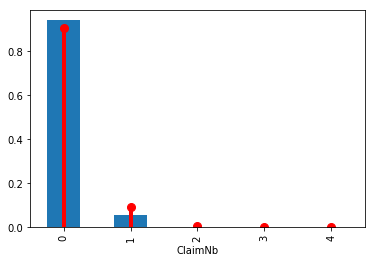

In [16]:
#df['ClaimNb'].plot(kind='hist', density = True)

df_plot = (
    df.loc[:, ['ClaimNb', 'Exposure']]
    .groupby('ClaimNb')
    .sum()
    .assign(Frequency_Observed = lambda x: x.Exposure / df['Exposure'].sum())
)

df_plot['Frequency_Observed'].plot(kind = 'bar')

mean = df['ClaimNb'].sum() / df['Exposure'].sum()
x = range(5)
plt.plot(x, scipy.stats.poisson.pmf(x, mean), 'ro', ms=8, mec='r')
plt.vlines(x=x, ymin=0, ymax=scipy.stats.poisson.pmf(x, mean), color='r', lw=4)
plt.xticks(x);

# Not too bad, visually.

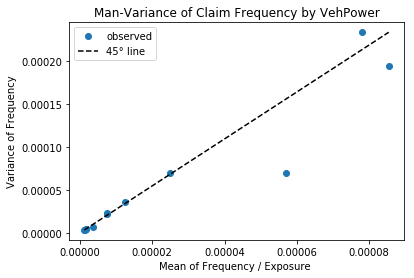

In [17]:
# Check mean-variance relationship for Poisson: Var[Y] = E[Y] / Exposure
# Estimate Var[Y] and E[Y]
# Plot estimates Var[Y] vs E[Y]/Exposure
# Note: We group by VehPower in order to have different E[Y].

def my_agg(x):
    """See https://stackoverflow.com/q/44635626"""
    names = {
        'Freq_mean': np.average(x['Freq'], weights=x['Exposure']),
        'Freq_var': var_weighted(x['Freq'], weights=x['Exposure'], method=2),
        'Exposure_sum': x['Exposure'].sum()
    }
    return pd.Series(names, index=['Freq_mean', 'Freq_var', 'Exposure_sum'])

df_plot = (df
           .assign(Freq = lambda x: x['ClaimNb']/x['Exposure'])
           .groupby('VehPower')
           .apply(my_agg)
          )

plt.plot(df_plot['Freq_mean']/df_plot['Exposure_sum'], df_plot['Freq_var'], '.',
         markersize=12, label='observed')

plt.plot([(df_plot['Freq_mean']/df_plot['Exposure_sum']).min(),
          (df_plot['Freq_mean']/df_plot['Exposure_sum']).max()],
         [df_plot['Freq_var'].min(), df_plot['Freq_var'].max()],
         'k--', label='45° line')
plt.xlabel('Mean of Frequency / Exposure ')
plt.ylabel('Variance of Frequency')
plt.legend()
plt.title('Man-Variance of Claim Frequency by VehPower');

# This is a strong confirmation for the use of a Poisson when fitting!
# Hint 1: If Y were normal distributed, one should see a horizontal line,
#         because for a Normal: Var[Y] ~ constant/Exposure.
# Hint 2: The 45° line is not even necessary, any straight line through the origin would be enough
#         for a simple reason:
#         1) A quasi-Poisson distribution has Var[Y] = phi * E[Y]/w
#         2) phi does not influence the estimation/fitting of E[Y] (thanks @ExponentialDispersionFamily)

### 4.2 Reproduce model GLM1 of the case study paper

R result on whole data set

```R
Call:
glm(formula = ClaimNb ~ VehPowerGLM + VehAgeGLM + DrivAgeGLM + 
    BonusMalusGLM + VehBrand + VehGas + DensityGLM + Region + 
    AreaGLM, family = poisson(), data = dat2, offset = log(Exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9002  -0.3784  -0.2894  -0.1630   6.8929  

Coefficients:
                Estimate Std. Error  z value Pr(>|z|)    
(Intercept)   -3.9869296  0.0366257 -108.856  < 2e-16 ***
VehPowerGLM5   0.1882444  0.0182221   10.331  < 2e-16 ***
VehPowerGLM6   0.2206928  0.0181219   12.178  < 2e-16 ***
VehPowerGLM7   0.1324376  0.0179406    7.382 1.56e-13 ***
VehPowerGLM8  -0.0729859  0.0270731   -2.696 0.007020 ** 
VehPowerGLM9   0.2132070  0.0200247   10.647  < 2e-16 ***
VehAgeGLM1     1.1663322  0.0162768   71.656  < 2e-16 ***
VehAgeGLM3    -0.2033232  0.0133646  -15.214  < 2e-16 ***
DrivAgeGLM1    0.0459512  0.0432388    1.063 0.287905    
DrivAgeGLM2   -0.3060585  0.0264092  -11.589  < 2e-16 ***
DrivAgeGLM3   -0.4285907  0.0219638  -19.513  < 2e-16 ***
DrivAgeGLM4   -0.2919377  0.0157723  -18.510  < 2e-16 ***
DrivAgeGLM6   -0.0704886  0.0142465   -4.948 7.51e-07 ***
DrivAgeGLM7    0.0020017  0.0224714    0.089 0.929020    
BonusMalusGLM  0.0230526  0.0003379   68.224  < 2e-16 ***
VehBrandB10    0.0081586  0.0370468    0.220 0.825696    
VehBrandB11    0.0896067  0.0396075    2.262 0.023675 *  
VehBrandB12    0.1231339  0.0175753    7.006 2.45e-12 ***
VehBrandB13    0.0570732  0.0410313    1.391 0.164236    
VehBrandB14   -0.1318432  0.0785812   -1.678 0.093387 .  
VehBrandB2     0.0011425  0.0153481    0.074 0.940659    
VehBrandB3     0.0004747  0.0219348    0.022 0.982734    
VehBrandB4     0.0003895  0.0298454    0.013 0.989587    
VehBrandB5     0.0717207  0.0249588    2.874 0.004059 ** 
VehBrandB6     0.0080993  0.0284873    0.284 0.776170    
VehGasRegular  0.0681720  0.0113837    5.989 2.12e-09 ***
DensityGLM     0.0313760  0.0120229    2.610 0.009062 ** 
RegionR11     -0.1237443  0.0233890   -5.291 1.22e-07 ***
RegionR21      0.0508008  0.0802838    0.633 0.526887    
RegionR22     -0.0100522  0.0493840   -0.204 0.838703    
RegionR23     -0.1388754  0.0586533   -2.368 0.017897 *  
RegionR25     -0.0521472  0.0412511   -1.264 0.206180    
RegionR26     -0.0800721  0.0457013   -1.752 0.079761 .  
RegionR31     -0.1790355  0.0320324   -5.589 2.28e-08 ***
RegionR41     -0.3070169  0.0422343   -7.269 3.61e-13 ***
RegionR42     -0.1097139  0.0877356   -1.251 0.211115    
RegionR43     -0.1765093  0.1330280   -1.327 0.184556    
RegionR52     -0.0784913  0.0249993   -3.140 0.001691 ** 
RegionR53      0.0215696  0.0221328    0.975 0.329781    
RegionR54     -0.1146011  0.0338761   -3.383 0.000717 ***
RegionR72     -0.1557227  0.0297364   -5.237 1.63e-07 ***
RegionR73     -0.1936586  0.0403100   -4.804 1.55e-06 ***
RegionR74      0.1204255  0.0632136    1.905 0.056773 .  
RegionR82      0.0085350  0.0187957    0.454 0.649761    
RegionR83     -0.3781741  0.0738928   -5.118 3.09e-07 ***
RegionR91     -0.1256964  0.0284714   -4.415 1.01e-05 ***
RegionR93     -0.0862625  0.0207796   -4.151 3.31e-05 ***
RegionR94      0.0607886  0.0652408    0.932 0.351462    
AreaGLM        0.0156128  0.0161290    0.968 0.333048    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 223932  on 678012  degrees of freedom
Residual deviance: 212603  on 677964  degrees of freedom
AIC: 282018

Number of Fisher Scoring iterations: 6
```

In [18]:
X = col_trans_GLM1.transform(df)
z = df['ClaimNb'].values
weight = df['Exposure'].values
# y = claims frequency
y = z / weight

In [19]:
# As a check, fit on whole data and compare to R
glm = GeneralizedLinearRegressor(family='poisson', alpha=0, fit_intercept=True, tol=1e-8)
glm.fit(X, y, sample_weight=weight)
print(f"Number of iterations: {glm.n_iter_}")
pd.DataFrame({'coefficient': np.concatenate(([glm.intercept_], glm.coef_))},
             index=['intercept'] + col_trans_GLM1_names)

Number of iterations: 6


,coefficient
intercept,-3.986930
VehPower_5,0.188244
VehPower_6,0.220693
VehPower_7,0.132438
VehPower_8,-0.072986
VehPower_9,0.213207
"VehAge_[0,1)",1.166332
"VehAge_(10,inf)",-0.203323
"DrivAge_[18,21)",0.045951
"DrivAge_[21,26)",-0.306058


### 4.3 Frequency GLM with Train and Test Data
From now on, we use claim number with positive claim amount 'ClaimNb_pos' and we devide the dataset into training set and test set with a 9:1 random split.

In [20]:
X = col_trans_GLM1.transform(df)
z = df['ClaimNb_pos'].values
weight = df['Exposure'].values
# y = claims frequency
y = z / weight

ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train, test = next(ss.split(y))

f_glm1 = GeneralizedLinearRegressor(family='poisson', alpha=0, fit_intercept=True)
f_glm1.fit(X[train], y[train], sample_weight=weight[train])
#pd.DataFrame({'coefficient': np.concatenate(([f_glm1.intercept_], f_glm1.coef_))},
#             index=['intercept'] + column_trans_names)

GeneralizedLinearRegressor(P1='identity', P2='identity', alpha=0,
                           check_input=True, copy_X=True, diag_fisher=False,
                           family='poisson', fit_dispersion=None,
                           fit_intercept=True, l1_ratio=0, link='auto',
                           max_iter=100, random_state=None, selection='cyclic',
                           solver='auto', start_params='guess', tol=0.0001,
                           verbose=0, warm_start=False)

In [21]:
# balance property of GLM with canonical link, like log-link for Poisson:
z[train].sum(), f_glm1.predict(X[train], sample_weight=weight[train]).sum()
# Note: glm.predict(.., sample_weight=w) = w * glm.predict(..)

(23785, 23785.000097829234)

In [22]:
# for Poisson deviance, note that the following are equivalent (with freq = count/weight)
# dev(observed count, predicted count) ~ dev(observed freq, predicted freq, sample_weight=weight)
print('training loss f_glm1: {}'.format(
     weight[train].sum()/len(train) * poisson_deviance(y[train], f_glm1.predict(X[train]), sample_weight=weight[train])))

print('training loss f_glm1: {}'.format(
    poisson_deviance(z[train], f_glm1.predict(X[train], sample_weight=weight[train]))))

print('testing loss f_glm1:  {}'.format(
    poisson_deviance(z[test], f_glm1.predict(X[test], sample_weight=weight[test]))))

print('testing loss Mean:    {}'.format(
    poisson_deviance(z[test],
                     np.average(y[train], weights=weight[train])*weight[test])))

training loss f_glm1: 0.2414864891047001
training loss f_glm1: 0.2414864891047001
testing loss f_glm1:  0.24189893958205727
testing loss Mean:    0.25291674783430484


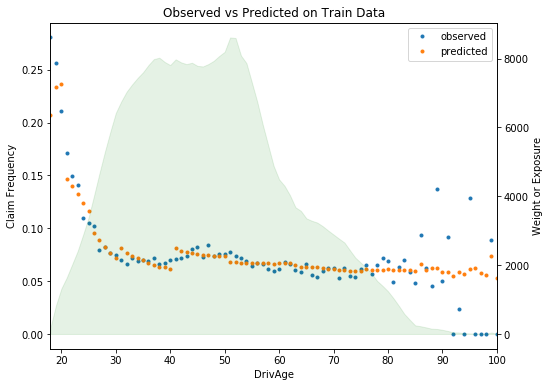

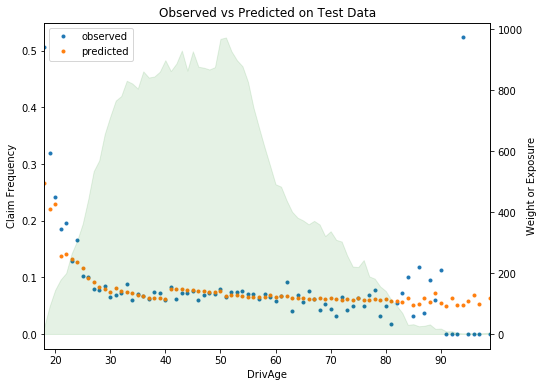

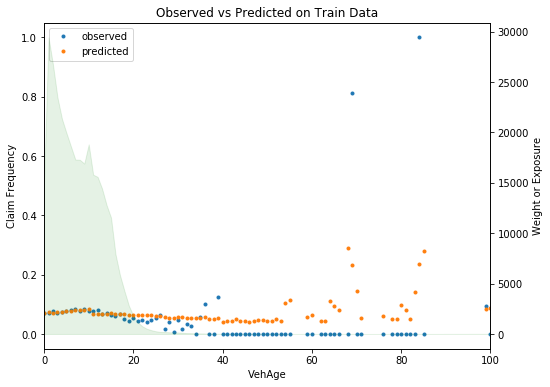

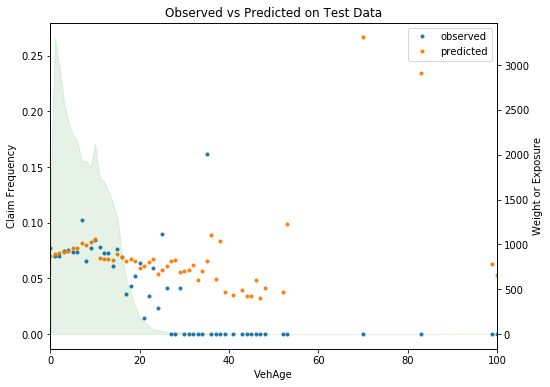

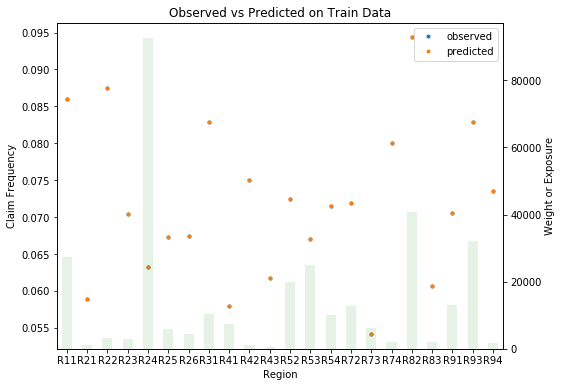

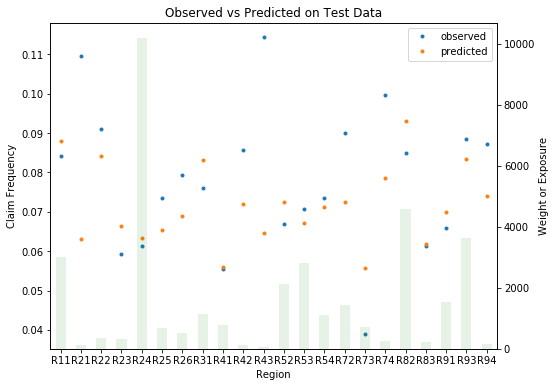

In [23]:
df_plot = df.copy()
df_plot['Freq_Observed'] = df_plot['ClaimNb_pos'] / df_plot['Exposure']
df_plot['Freq_Predicted'] = f_glm1.predict(X)

# plot DivAge
plot_obs_pred(df_plot.iloc[train], 'DrivAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Train Data')

plot_obs_pred(df_plot.iloc[test], 'DrivAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Test Data')

# plot VehAge
plot_obs_pred(df_plot.iloc[train], 'VehAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Train Data')

plot_obs_pred(df_plot.iloc[test], 'VehAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Test Data')

# plot Region
plot_obs_pred(df_plot.iloc[train], 'Region', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Train Data',
              kind_weight='bar')

plot_obs_pred(df_plot.iloc[test], 'Region', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Test Data',
              kind_weight='bar')

## 5 Severity GLM -  Gamma Distribution <a class="anchor" id="5-severity"></a>
We fit a GLM model for the severity with the same features as the freq model.
The severity $y$ is the average claim size.
We define:
- $z$: total claim amount cut at 100000
- $w$: number of claims (with positive claim amount!)
- $y = \frac{w}{w}$: severity

### 5.1 Why Poisson distributions
The severity $y$ is a positive, real number, $y \in (0, \infty)$. Theoretically, especially for liability claims, one could have arbitrary large numbers&mdash;very unlikely but possible. A very simple distribution for this range is an Exponential distribution, or its next best extension, a Gamma distribution $y \sim Gamma$. In the insurance industry, it is well known that the severity might be skewed and have heavy tails, i.e. a few very large losses.

A Gamma distribution as mean-variance relation $\mathrm{Var}[Y] = \frac{\phi}{w} \mathrm{E}[Y]^2$. Note that the dispersion $\phi$ does not influence the estimation of $E[\mu]$.

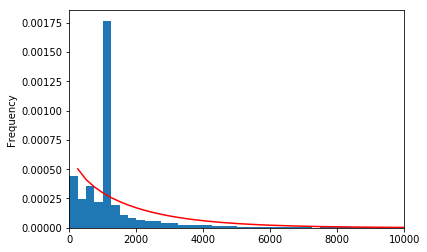

In [24]:
df_plot = (
    df.loc[:, ['ClaimAmountCut', 'ClaimNb_pos']]
    .query('ClaimNb_pos > 0')
    .assign(Severity_Observed = lambda x: x['ClaimAmountCut'] / df['ClaimNb_pos'])
)

df_plot['Severity_Observed'].plot.hist(bins=400, density=True)

x = np.linspace(0, 1e5, num=400)
plt.plot(x,
         scipy.stats.gamma.pdf(x, *scipy.stats.gamma.fit(df_plot['Severity_Observed'], floc=0)),
         'r-')
plt.xlim(left=0, right = 1e4);
#plt.xticks(x);

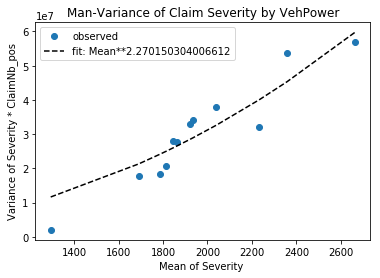

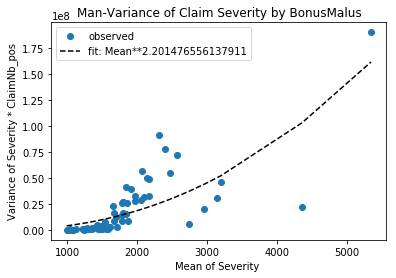

In [25]:
# Check mean-variance relationship for Gamma: Var[Y] = E[Y]^2 / Exposure
# Estimate Var[Y] and E[Y]
# Plot estimates Var[Y] vs E[Y]^s/Exposure
# Note: We group by VehPower and BonusMalus in order to have different E[Y].

def my_agg(x):
    """See https://stackoverflow.com/q/44635626"""
    names = {
        'Sev_mean': np.average(x['Sev'], weights=x['ClaimNb_pos']),
        'Sev_var': var_weighted(x['Sev'], weights=x['ClaimNb_pos'], method=1),
        'ClaimNb_pos_sum': x['ClaimNb_pos'].sum()
    }
    return pd.Series(names, index=['Sev_mean', 'Sev_var', 'ClaimNb_pos_sum'])

for col in ['VehPower', 'BonusMalus']:
    claims = df.groupby(col)['ClaimNb_pos'].sum()
    df_plot = (df.loc[df[col].isin(claims[claims >= 4].index), :]
               .query('ClaimNb_pos > 0')
               .assign(Sev = lambda x: x['ClaimAmountCut']/x['ClaimNb_pos'])
               .groupby(col)
               .apply(my_agg)
              )

    plt.plot(df_plot['Sev_mean'], df_plot['Sev_var'] * df_plot['ClaimNb_pos_sum'], '.',
             markersize=12, label='observed')

    # fit: mean**p/claims
    p = optimize.curve_fit(lambda x, p: np.power(x, p),
                           df_plot['Sev_mean'].values,
                           df_plot['Sev_var'] * df_plot['ClaimNb_pos_sum'],
                           p0 = [2])[0][0]
    df_fit = pd.DataFrame({'x': df_plot['Sev_mean'],
                           'y': np.power(df_plot['Sev_mean'], p)})
    df_fit = df_fit.sort_values('x')

    plt.plot(df_fit.x, df_fit.y,
             'k--', label='fit: Mean**{}'.format(p))
    plt.xlabel('Mean of Severity ')
    plt.ylabel('Variance of Severity * ClaimNb_pos')
    plt.legend()
    plt.title('Man-Variance of Claim Severity by {}'.format(col))
    plt.show()

# This is good confirmation to use the Gamma.
# Note: The data seems to be slightly heavier tailed than a Gamma, because estimated p > 2.
# Hint: If Y were normal distributed, one should see a horizontal line, because Var[Y] ~ constant/Exposure
#       and the fit should give p ~ 0

### 5.2 Severity GLM with Train and Test Data
We fit a GLM model for the severity with the same features as the freq model.

Note:
- We filter out ClaimAmount == 0 as the Gamma distribution as support on $(0, \infty)$ not $[0, \infty)$
- We use ClaimNb_pos as sample weights.
- We use the same split in train and test data such that we can predict the final claim amount on the test set.

In [26]:
idx = df['ClaimAmountCut'].values > 0
X = col_trans_GLM1.transform(df)  # not necessary, still the same
z = df['ClaimAmountCut'].values
weight = df['ClaimNb_pos'].values
# y = claims severity
y = np.zeros_like(z)  # zeros will never be used
y[idx] = z[idx] / weight[idx]

# we also need to represent train and test as boolean indices
itrain = np.zeros(y.shape, dtype='bool')
itest = np.zeros(y.shape, dtype='bool')
itrain[train] = True
itest[test] = True
# simplify life
itrain = idx & itrain
itest = idx & itest

In [27]:
s_glm1 = GeneralizedLinearRegressor(family='gamma', alpha=0, fit_intercept=True)
s_glm1.fit(X[itrain], y[itrain], sample_weight=weight[itrain])

pd.DataFrame({'coefficient': np.concatenate(([s_glm1.intercept_], s_glm1.coef_))},
             index=['intercept'] + col_trans_GLM1_names)

,coefficient
intercept,7.211682
VehPower_5,-0.087184
VehPower_6,0.078806
VehPower_7,0.015878
VehPower_8,-0.037153
VehPower_9,0.055670
"VehAge_[0,1)",0.058694
"VehAge_(10,inf)",-0.025445
"DrivAge_[18,21)",0.502338
"DrivAge_[21,26)",0.049735


In [28]:
print('training loss s_glm1: {}'.format(
    gamma_deviance(y[itrain], s_glm1.predict(X[itrain]), sample_weight=weight[itrain])))

print('testing loss s_glm1:  {}'.format(
    poisson_deviance(y[itest], s_glm1.predict(X[itest]), sample_weight=weight[itest])))

print('testing loss Mean:    {}'.format(
    poisson_deviance(y[itest],
                     np.average(z[itrain], weights=weight[itrain])*np.ones_like(z[itest]),
                     sample_weight=weight[itest])))

# Clear overfit!

training loss s_glm1: 1.2916117795069284
testing loss s_glm1:  3092.192062808907
testing loss Mean:    3113.368923796537


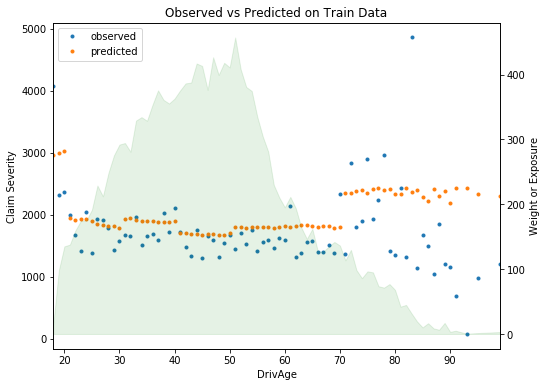

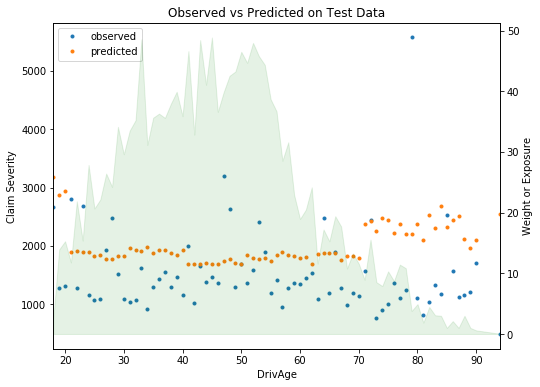

In [29]:
df_plot = df.copy()
df_plot['Sev_Observed'] = 0
df_plot.loc[idx, 'Sev_Observed'] = df_plot.loc[idx, 'ClaimAmountCut'] / df_plot.loc[idx, 'ClaimNb_pos']
df_plot['Sev_Predicted'] = s_glm1.predict(X)

# plot DivAge
plot_obs_pred(df_plot.loc[itrain], 'DrivAge', 'Sev_Observed', 'Sev_Predicted', 'Exposure',
              y_label='Claim Severity', title='Observed vs Predicted on Train Data')

plot_obs_pred(df_plot.iloc[itest], 'DrivAge', 'Sev_Observed', 'Sev_Predicted', 'Exposure',
              y_label='Claim Severity', title='Observed vs Predicted on Test Data')

TODO: Better model for severity

TODO: Put together freq * sev

In [30]:
#Put together freq * sev together
print("Total claim amount on train set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[train].sum(),
            np.sum(df['Exposure'].values[train] * f_glm1.predict(X[train]) * s_glm1.predict(X[train])))
     )

print("Total claim amount on test set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[test].sum(),
            np.sum(df['Exposure'].values[test] * f_glm1.predict(X[test]) * s_glm1.predict(X[test])))
     )

Total claim amount on train set, observed = 44594644.68, predicted = 44582455.508657046
Total claim amount on test set, observed = 4707551.37, predicted = 4952514.0830185115


In [31]:
#TODO: Evaluate Metric for Claim Amount on test set. Which metric? Tweedie p=1.5? Squared error?

#TODO: QQ-Plot for distributions

## TODO: Frequency ElasticNet

In [ ]:
# elastic net
#ct_enet, cn_enet = gen_col_trans(drop=False)
#ct_enet.fit(insurance_data);
#X2 = ct_enet.transform(insurance_data)
#
#glm2 = GeneralizedLinearRegressor(family='poisson', alpha=0.5, l1_ratio=0.9, fit_intercept=True,
#                                 tol=1e-3)
#glm2.fit(X2[train], y[train], sample_weight=weight[train])

In [ ]:
#print('in-sample loss: {}'.format(
#    poisson_deviance(z[train], glm.predict(X[train], sample_weight=weight[train]))))
#
#print('out-of-sample loss: {}'.format(
#    poisson_deviance(z[test], glm.predict(X[test], sample_weight=weight[test]))))
#
#print('in-sample loss: {}'.format(
#    poisson_deviance(z[train], glm2.predict(X2[train], sample_weight=weight[train]))))
#
#print('out-of-sample loss: {}'.format(
#    poisson_deviance(z[test], glm2.predict(X2[test], sample_weight=weight[test]))))

In [ ]:
pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X3 = VarianceThreshold().fit_transform(
    StandardScaler().fit_transform(
        pf.fit_transform(X2.toarray())))

glm3 = GeneralizedLinearRegressor(family='poisson', alpha=1, l1_ratio=0.9, fit_intercept=True,
                                  tol=1e-3)
glm3.fit(X3[train], y[train], sample_weight=weight[train])

print('in-sample loss: {}'.format(
    poisson_deviance(z[train], glm3.predict(X3[train], sample_weight=weight[train]))))

print('out-of-sample loss: {}'.format(
    poisson_deviance(z[test], glm3.predict(X3[test], sample_weight=weight[test]))))

In [ ]:
pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X3 = VarianceThreshold().fit_transform(
    StandardScaler().fit_transform(
        pf.fit_transform(X2.toarray)))
glm3 = GeneralizedLinearRegressor(family='poisson', alpha=1, l1_ratio=0.9, fit_intercept=True,
                                  tol=1e-3)
glm3.fit(X3[train], y[train], sample_weight=weight[train])

print('in-sample loss: {}'.format(
    poisson_deviance(z[train], glm3.predict(X3[train], sample_weight=weight[train]))))

print('out-of-sample loss: {}'.format(
    poisson_deviance(z[test], glm3.predict(X3[test], sample_weight=weight[test]))))

In [ ]:
VarianceThreshold().fit_transform(
    StandardScaler().fit_transform(
        pf.fit_transform(X2.toarray()))).shape